In [1]:
# Implementation of the SAC algorithm based on https://github.com/pranz24/pytorch-soft-actor-critic# paper: https://arxiv.org/pdf/1801.01290

import argparse
import datetime
import gym
import numpy as np
import itertools
import torch
from sac import SAC
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from replay_memory import ReplayMemory

In [2]:

class arguments():
    def __init__(self):
        self.env_name = "MountainCarContinuous-v0"
        self.policy = "Gaussian"
        self.gamma = 0.99
        self.tau=0.005
        self.lr = 0.0003
        self.alpha = 0.2
        self.automatic_entropy_tuning = False
        self.seed=123456
        self.batch_size=256
        self.num_steps=100000
        self.hidden_size=256
        self.updates_per_step=1
        self.start_steps=30000
        self.target_update_interval=1
        self.replay_size = 100000
        self.cuda = False
        self.eval = True #Returns Average over 10 episodes

#print(env._max_episode_steps)
args = arguments()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
new_step_api = False #Much slower with new step API
env = gym.make(args.env_name, new_step_api = new_step_api)
env.reset(seed = args.seed)
env.action_space.seed(args.seed)

torch.manual_seed(args.seed)
np.random.seed(args.seed)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
agent = SAC(env.observation_space.shape[0], env.action_space, args)

num_inputs: 2
action_space.shape[0]: (1,)
args.hidden_size: 256


In [5]:
# Memory
memory = ReplayMemory(args.replay_size, args.seed)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#Tensorboard
#writer = SummaryWriter('runs/{}_SAC_{}_{}_{}'.format(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), args.env_name, args.policy, "autotune" if args.automatic_entropy_tuning else ""))

In [7]:
# Training Loop
total_numsteps = 0
updates = 0
policy_losses = []
rewards =[]
critic_1_losses = []
critic_2_losses = []

for i_episode in itertools.count(1):
    episode_reward = 0
    episode_steps = 0
    done = False
    state = env.reset()

    while not done:
        if args.start_steps > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > args.batch_size:
            # Number of updates per step in environment
            for i in range(args.updates_per_step):
                # Update parameters of all the networks
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, args.batch_size, updates)
                policy_losses.append(policy_loss)
                critic_1_losses.append(critic_1_loss)
                critic_2_losses.append(critic_2_loss)
                updates += 1

        if new_step_api:
          next_state, reward, _, _, done = env.step(action) # Step
        else:
          next_state, reward, done, _ = env.step(action) # Step


        episode_steps += 1
        total_numsteps += 1
        episode_reward += reward


        # Ignore the "done" signal if it comes from hitting the time horizon.
        # (https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py)
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask) # Append transition to memory

        state = next_state

    if total_numsteps > args.num_steps:
        break

    rewards.append(episode_reward)
    print("Episode: {}, total numsteps: {}, episode steps: {}, reward: {}".format(i_episode, total_numsteps, episode_steps, round(episode_reward, 2)))


    if i_episode % 10 == 0 and args.eval is True:
        avg_reward = 0.
        episodes = 10
        for _  in range(episodes):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.select_action(state, evaluate=True)

                next_state, reward, done, _ = env.step(action)
                episode_reward += reward


                state = next_state
            avg_reward += episode_reward
        avg_reward /= episodes


        print("----------------------------------------")
        print("Test Episodes: {}, Avg. Reward: {}".format(episodes, round(avg_reward, 2)))
        print("----------------------------------------")

env.close()


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 1, total numsteps: 999, episode steps: 999, reward: -33.15
Episode: 2, total numsteps: 1998, episode steps: 999, reward: -32.73
Episode: 3, total numsteps: 2997, episode steps: 999, reward: -35.34
Episode: 4, total numsteps: 3996, episode steps: 999, reward: -32.3
Episode: 5, total numsteps: 4995, episode steps: 999, reward: -33.4
Episode: 6, total numsteps: 5994, episode steps: 999, reward: -32.37
Episode: 7, total numsteps: 6993, episode steps: 999, reward: -33.92
Episode: 8, total numsteps: 7992, episode steps: 999, reward: -33.3
Episode: 9, total numsteps: 8991, episode steps: 999, reward: -33.19
Episode: 10, total numsteps: 9990, episode steps: 999, reward: -33.03
----------------------------------------
Test Episodes: 10, Avg. Reward: -0.0
----------------------------------------
Episode: 11, total numsteps: 10989, episode steps: 999, reward: -34.93
Episode: 12, total numsteps: 11988, episode steps: 999, reward: -35.17
Episode: 13, total numsteps: 12987, episode steps: 9

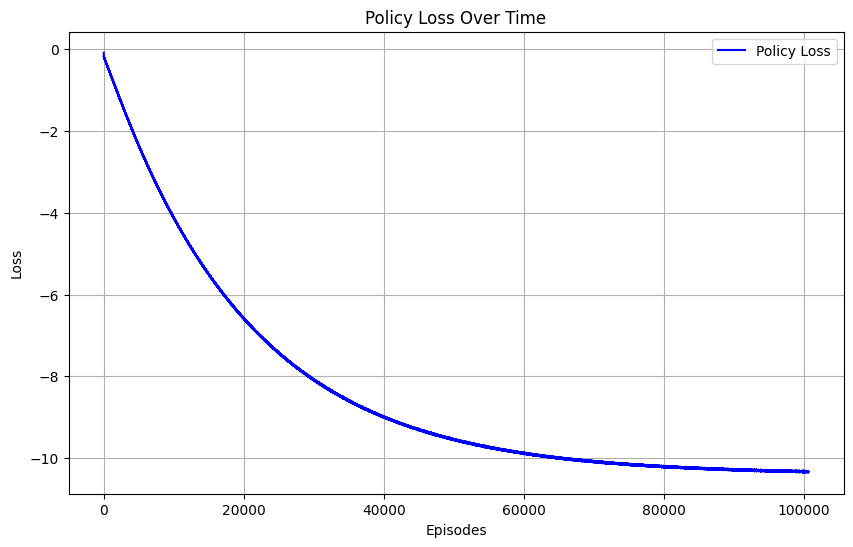

In [8]:
# Plotting the losses
plt.figure(figsize=(10, 6))
# Plot policy losses
plt.plot(policy_losses, label='Policy Loss', color='blue')

plt.title('Policy Loss Over Time')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


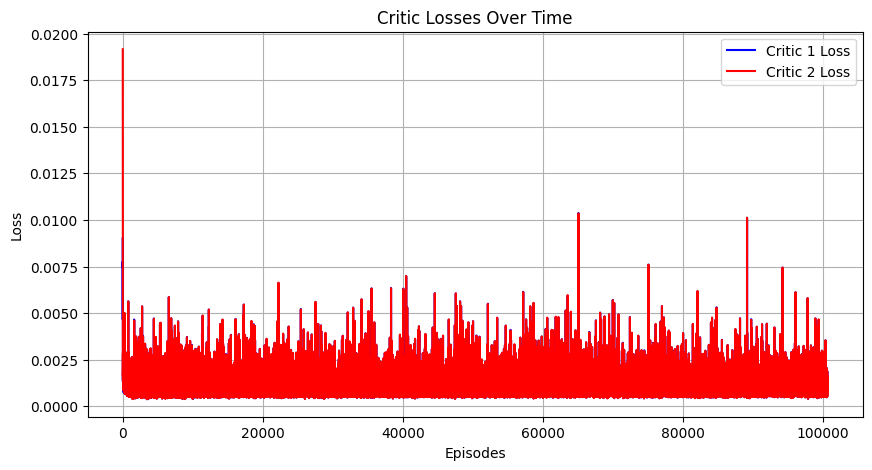

In [9]:
# Plotting critic losses
plt.figure(figsize=(10, 5))

# Plotting critic 1 loss
plt.plot(critic_1_losses, label='Critic 1 Loss', color='blue')

# Plotting critic 2 loss
plt.plot(critic_2_losses, label='Critic 2 Loss', color='red')

plt.title('Critic Losses Over Time')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

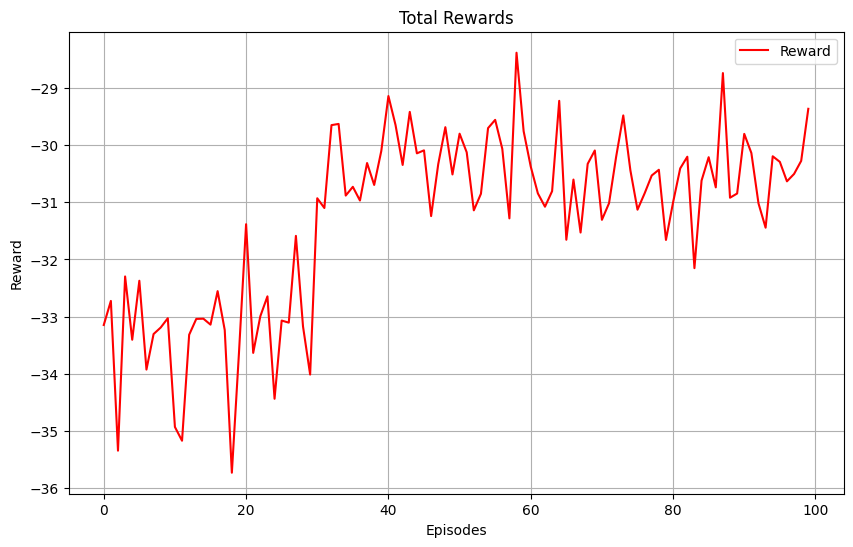

In [10]:
# Plotting the losses
plt.figure(figsize=(10, 6))
# Plot critic losses
plt.plot(rewards, label='Reward', color='red')
plt.xlabel("Episode")
plt.ylabel("Total reward")


plt.title('Total Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
agent.save_checkpoint(args.env_name)

Saving models to checkpoints/sac_checkpoint_MountainCarContinuous-v0_


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
